In [1]:
import os
import sys
os.environ["PYSPARK_SUBMIT_ARGS"]='pyspark-shell'
os.environ["PYSPARK_PYTHON"]='python3'
os.environ["SPARK_HOME"]='/usr/hdp/current/spark2-client'

spark_home = os.environ.get('SPARK_HOME', None)
if not spark_home:
    raise ValueError('SPARK_HOME environment variable is not set')
sys.path.insert(0, os.path.join(spark_home, 'python'))
sys.path.insert(0, os.path.join(spark_home, 'python/lib/py4j-0.10.4-src.zip'))
os.environ["PYSPARK_PYTHON"] = 'python3'
exec(open(os.path.join(spark_home, 'python/pyspark/shell.py')).read())

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 2.3.0
      /_/

Using Python version 3.6.4 (default, Jan 28 2018 00:00:00)
SparkSession available as 'spark'.


In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import seaborn as sns

In [4]:
spark

## How to read from input source

In [5]:
spark.read

## The loading pipeline
```python
spark.read\
     .format(...)\
     .option(key, value)\
     .option(key, value)\
     .load(path)
```

In [6]:
df = spark.read\
          .format("csv")\
          .option("sep", "|")\
          .load("/share/ml-100k/u.user")

In [7]:
df

DataFrame[_c0: string, _c1: string, _c2: string, _c3: string, _c4: string]

In [9]:
 df.show(1)

+---+---+---+----------+-----+
|_c0|_c1|_c2|       _c3|  _c4|
+---+---+---+----------+-----+
|  1| 24|  M|technician|85711|
+---+---+---+----------+-----+
only showing top 1 row



In [10]:
df.take(1)

[Row(_c0='1', _c1='24', _c2='M', _c3='technician', _c4='85711')]

## Schema!

In [11]:
from pyspark.sql.types import *

In [12]:
schema = StructType(fields=[
    StructField("user_id", IntegerType()),
    StructField("age", IntegerType()),
    StructField("gender", StringType()),
    StructField("occupation", StringType()),
    StructField("zip", IntegerType())
])

In [13]:
df = spark.read\
          .schema(schema)\
          .format("csv")\
          .option("sep", "|")\
          .load("/share/ml-100k/u.user")

In [14]:
df

DataFrame[user_id: int, age: int, gender: string, occupation: string, zip: int]

In [15]:
df.show(5)

+-------+---+------+----------+-----+
|user_id|age|gender|occupation|  zip|
+-------+---+------+----------+-----+
|      1| 24|     M|technician|85711|
|      2| 53|     F|     other|94043|
|      3| 23|     M|    writer|32067|
|      4| 24|     M|technician|43537|
|      5| 33|     F|     other|15213|
+-------+---+------+----------+-----+
only showing top 5 rows



## So, the actual loading pipeline is
```python
spark.read\
     .schema(schema)\
     .format(...)\
     .option(key, value)\
     .option(key, value)\
     .load(path)
```

## There are also some convenient wrappers

In [12]:
df = spark.read.csv("/share/ml-100k/u.user", schema=schema, sep="|")

In [13]:
df

DataFrame[user_id: int, age: int, gender: string, occupation: string, zip: int]

In [129]:
df.show(5)

+-------+---+------+----------+-----+
|user_id|age|gender|occupation|  zip|
+-------+---+------+----------+-----+
|      1| 24|     M|technician|85711|
|      2| 53|     F|     other|94043|
|      3| 23|     M|    writer|32067|
|      4| 24|     M|technician|43537|
|      5| 33|     F|     other|15213|
+-------+---+------+----------+-----+
only showing top 5 rows



# !FIXME! Add JDBC example when sqlite is available

## Tons of data sources with a unified API!
+ CSV
+ JSON
+ Hive
+ HBase
+ Cassandra
+ MySQL
+ PostgreSQL
+ Parquet
+ ORC
+ Kafka
+ ElasticSearch
+ Amazon S3
+ ...and more through custom connectors

# Здесь должны быть куски про отличие от RDD еще и в схеме!

In [17]:
!hdfs dfs -tail /user/pavel.klemenkov/data/lecture02/logsM.txt

In [18]:
log_schema = StructType(fields=[
    StructField("ip", StringType()),
    StructField("timestamp", LongType()),
    StructField("url", StringType()),
    StructField("size", IntegerType()),
    StructField("code", IntegerType()),
    StructField("ua", StringType())
])

In [19]:
log = spark.read.csv("/user/pavel.klemenkov/data/lecture02/logsM.txt", sep="\t", schema=log_schema).cache()

In [20]:
log

DataFrame[ip: string, timestamp: bigint, url: string, size: int, code: int, ua: string]

In [21]:
log.rdd.getNumPartitions()

1

In [23]:
log = log.repartition(4)

In [24]:
log.show(5)

+--------------+--------------+--------------------+----+----+--------------------+
|            ip|     timestamp|                 url|size|code|                  ua|
+--------------+--------------+--------------------+----+----+--------------------+
|  49.105.15.79|20140127041332|http://lenta.ru/5...| 184| 509|Chrome/5.0 compat...|
|222.131.187.37|20140112193801|http://news.mail....| 903| 504|Chrome/5.0 (compa...|
|222.131.187.37|20140122151429|http://lenta.ru/1...|  89| 502|Safari/5.0 (Windo...|
| 33.49.147.163|20140416123526|http://news.yande...|  29| 409|Firefox/5.0 (comp...|
| 33.49.147.163|20140410014351|http://newsru.com...|1088| 409|Chrome/5.0 compat...|
+--------------+--------------+--------------------+----+----+--------------------+
only showing top 5 rows



## !FIXME! SQL queries for DF

## Projections and filters
Projection is a subset of columns

Filter is a asubset of rows

In [25]:
log.select("ip", "code").show(5)

+---------------+----+
|             ip|code|
+---------------+----+
|   25.62.10.220| 306|
|   49.105.15.79| 101|
|   49.105.15.79| 101|
|135.124.143.193| 303|
|135.124.143.193| 303|
+---------------+----+
only showing top 5 rows



In [26]:
 log.select(log.ip, log.code).show(5)

+---------------+----+
|             ip|code|
+---------------+----+
|   25.62.10.220| 306|
|   49.105.15.79| 101|
|   49.105.15.79| 101|
|135.124.143.193| 303|
|135.124.143.193| 303|
+---------------+----+
only showing top 5 rows



In [27]:
log.ip

Column<b'ip'>

## Aliasing

In [28]:
log.select(log.ip,
           log.code.alias("response")).show(5)

+---------------+--------+
|             ip|response|
+---------------+--------+
|   25.62.10.220|     306|
|   49.105.15.79|     101|
|   49.105.15.79|     101|
|135.124.143.193|     303|
|135.124.143.193|     303|
+---------------+--------+
only showing top 5 rows



In [29]:
import pyspark.sql.functions as f

In [30]:
log.select("ip", 
           f.col("code").alias("response")).show(5)

+---------------+--------+
|             ip|response|
+---------------+--------+
|   25.62.10.220|     306|
|   49.105.15.79|     101|
|   49.105.15.79|     101|
|135.124.143.193|     303|
|135.124.143.193|     303|
+---------------+--------+
only showing top 5 rows



## Good ol' Pandas

In [31]:
log[["ip", "code"]].show(5)

+---------------+----+
|             ip|code|
+---------------+----+
|   25.62.10.220| 306|
|   49.105.15.79| 101|
|   49.105.15.79| 101|
|135.124.143.193| 303|
|135.124.143.193| 303|
+---------------+----+
only showing top 5 rows



In [32]:
log[[log.ip, log.code.alias("response")]].show(5)

+---------------+--------+
|             ip|response|
+---------------+--------+
|   25.62.10.220|     306|
|   49.105.15.79|     101|
|   49.105.15.79|     101|
|135.124.143.193|     303|
|135.124.143.193|     303|
+---------------+--------+
only showing top 5 rows



## Filtering

In [33]:
log.filter("code == 200").show(5)

+--------------+--------------+--------------------+----+----+--------------------+
|            ip|     timestamp|                 url|size|code|                  ua|
+--------------+--------------+--------------------+----+----+--------------------+
| 75.208.40.166|20140326084231|http://news.yande...| 955| 200|Opera/5.0 (Window...|
|197.72.248.141|20140404122749|http://newsru.com...| 884| 200|Opera/5.0 (compat...|
| 75.208.40.166|20140216075757|http://news.rambl...|1337| 200|Firefox/5.0 (comp...|
|168.255.93.197|20140213033139|http://news.yande...|1004| 200|Chrome/5.0 (Windo...|
|197.72.248.141|20140403130026|http://news.yande...| 856| 200|Opera/5.0 (compat...|
+--------------+--------------+--------------------+----+----+--------------------+
only showing top 5 rows



In [34]:
log.filter(log.code == 200).show(5, truncate=False)

+--------------+--------------+------------------------------+----+----+-----------------------------------------------------------------------------------------------------------------------------+
|ip            |timestamp     |url                           |size|code|ua                                                                                                                           |
+--------------+--------------+------------------------------+----+----+-----------------------------------------------------------------------------------------------------------------------------+
|75.208.40.166 |20140326084231|http://news.yandex.ru/2002966 |955 |200 |Opera/5.0 (Windows; U; MSIE 9.0; Windows NT 8.1; Trident/5.0; .NET4.0E; en-AU)                                               |
|197.72.248.141|20140404122749|http://newsru.com/7833710     |884 |200 |Opera/5.0 (compatible; MSIE 9.0; Windows NT 6.1; WOW64; Trident/5.0; chromeframe/12.0.742.112)                               |
|75.2

In [35]:
log.filter("code == 200 AND url LIKE '%rambler%'").show(5, truncate=False, vertical=True)

-RECORD 0----------------------------------------------------------------------------------------------------------------------------------
 ip        | 33.49.147.163                                                                                                                 
 timestamp | 20140317090245                                                                                                                
 url       | http://news.rambler.ru/1667841                                                                                                
 size      | 166                                                                                                                           
 code      | 200                                                                                                                           
 ua        | Safari/5.0 (Windows; U; MSIE 9.0; Windows NT 6.0; Win64; x64; Trident/5.0; .NET CLR 3.8.50799; Media Center PC 6.0; .NET4.0E) 
-RECORD 1-----------

In [36]:
log.filter((log.code == 200) & (log.url.like("%rambler%"))).show(5)

+-------------+--------------+--------------------+----+----+--------------------+
|           ip|     timestamp|                 url|size|code|                  ua|
+-------------+--------------+--------------------+----+----+--------------------+
|33.49.147.163|20140317090245|http://news.rambl...| 166| 200|Safari/5.0 (Windo...|
|75.208.40.166|20140310132240|http://news.rambl...|1107| 200|Opera/5.0 (compat...|
|33.49.147.163|20140330043133|http://news.rambl...| 945| 200|Chrome/5.0 (compa...|
|33.49.147.163|20140329134621|http://news.rambl...|1593| 200|Firefox/5.0 (comp...|
|33.49.147.163|20140106045941|http://news.rambl...| 671| 200|Firefox/5.0 (comp...|
+-------------+--------------+--------------------+----+----+--------------------+
only showing top 5 rows



## Good ol' Pandas

In [37]:
log[(log.code == 200) & (log.url.like("%rambler%"))].show(5)

+-------------+--------------+--------------------+----+----+--------------------+
|           ip|     timestamp|                 url|size|code|                  ua|
+-------------+--------------+--------------------+----+----+--------------------+
|33.49.147.163|20140317090245|http://news.rambl...| 166| 200|Safari/5.0 (Windo...|
|75.208.40.166|20140310132240|http://news.rambl...|1107| 200|Opera/5.0 (compat...|
|33.49.147.163|20140330043133|http://news.rambl...| 945| 200|Chrome/5.0 (compa...|
|33.49.147.163|20140329134621|http://news.rambl...|1593| 200|Firefox/5.0 (comp...|
|33.49.147.163|20140106045941|http://news.rambl...| 671| 200|Firefox/5.0 (comp...|
+-------------+--------------+--------------------+----+----+--------------------+
only showing top 5 rows



## Alltogether

In [38]:
log[(log.code == 200) & (log.url.like("%rambler%"))][["ip", "code"]].show(5)

+---------------+----+
|             ip|code|
+---------------+----+
| 197.72.248.141| 200|
|247.182.249.253| 200|
|  75.208.40.166| 200|
|  75.208.40.166| 200|
|   25.62.10.220| 200|
+---------------+----+
only showing top 5 rows



## Functions
Three types:
+ mapping (one to one)
+ generating (one to many)
+ aggregating (many to one)

In [150]:
log.select("ua", f.length("ua")).show(5)

+--------------------+----------+
|                  ua|length(ua)|
+--------------------+----------+
|Safari/5.0 (compa...|        95|
|Safari/5.0 (compa...|       109|
|Chrome/5.0 (compa...|        74|
|Safari/5.0 (Windo...|        79|
|Chrome/5.0 (compa...|       106|
+--------------------+----------+
only showing top 5 rows



In [151]:
log.select("ua", f.length("ua").alias("length")).show(5)

+--------------------+------+
|                  ua|length|
+--------------------+------+
|Safari/5.0 (compa...|    95|
|Safari/5.0 (compa...|   109|
|Chrome/5.0 (compa...|    74|
|Safari/5.0 (Windo...|    79|
|Chrome/5.0 (compa...|   106|
+--------------------+------+
only showing top 5 rows



In [39]:
log.select(f.concat("url", "?utm_medium=email")).show(5)

AnalysisException: "cannot resolve '`?utm_medium=email`' given input columns: [ip, size, code, url, ua, timestamp];;\n'Project [concat(url#104, '?utm_medium=email) AS concat(url, ?utm_medium=email)#820]\n+- AnalysisBarrier\n      +- Repartition 4, true\n         +- Relation[ip#102,timestamp#103L,url#104,size#105,code#106,ua#107] csv\n"

**`concat` needs `Column` type as argument. `lit` creates new `Column` from a literal value**

In [40]:
log.select(f.concat("url", f.lit("?utm_medium=email")).alias("newurl")).show(5, False)

+-----------------------------------------------+
|newurl                                         |
+-----------------------------------------------+
|http://newsru.com/4608402?utm_medium=email     |
|http://news.yandex.ru/4761980?utm_medium=email |
|http://lenta.ru/2662415?utm_medium=email       |
|http://news.mail.ru/5550951?utm_medium=email   |
|http://news.rambler.ru/2396720?utm_medium=email|
+-----------------------------------------------+
only showing top 5 rows



## Explosions!

In [41]:
log.select("ua", f.split("ua", " ").alias("word_list")).show(5, False, True)

-RECORD 0---------------------------------------------------------------------------------------------------------------
 ua        | Safari/5.0 (compatible; MSIE 9.0; Windows NT 6.1; WOW64; Trident/5.0; chromeframe/12.0.742.112)            
 word_list | [Safari/5.0, (compatible;, MSIE, 9.0;, Windows, NT, 6.1;, WOW64;, Trident/5.0;, chromeframe/12.0.742.112)] 
-RECORD 1---------------------------------------------------------------------------------------------------------------
 ua        | Safari/5.0 (compatible; MSIE 9.0; Windows NT 6.1; WOW64; Trident/5.0; chromeframe/12.0.742.112)            
 word_list | [Safari/5.0, (compatible;, MSIE, 9.0;, Windows, NT, 6.1;, WOW64;, Trident/5.0;, chromeframe/12.0.742.112)] 
-RECORD 2---------------------------------------------------------------------------------------------------------------
 ua        | Safari/5.0 (compatible; MSIE 9.0; Windows NT 6.1; WOW64; Trident/5.0; chromeframe/12.0.742.112)            
 word_list | [Safari/5.0, (compa

**You can even select individual elements of the list!**

In [42]:
log.select("ua", f.split("ua", " ").alias("word_list"))\
   .select(f.col("word_list")[0], f.col("word_list")[1])\
   .show(5)

+------------+------------+
|word_list[0]|word_list[1]|
+------------+------------+
|  Safari/5.0|(compatible;|
|  Safari/5.0|(compatible;|
|  Safari/5.0|(compatible;|
|  Safari/5.0|(compatible;|
|  Safari/5.0|(compatible;|
+------------+------------+
only showing top 5 rows



In [43]:
log.select("ua", f.split("ua", " ").alias("word_list"))\
   .select(f.explode("word_list").alias("word")).show(10)

+--------------------+
|                word|
+--------------------+
|          Safari/5.0|
|        (compatible;|
|                MSIE|
|                9.0;|
|             Windows|
|                  NT|
|                6.1;|
|              WOW64;|
|        Trident/5.0;|
|chromeframe/12.0....|
+--------------------+
only showing top 10 rows



## Joins

In [44]:
!hdfs dfs -tail /user/pavel.klemenkov/data/lecture02/ipDataM.txt

96.67	Khanty���Mansi
197.72.248.141	Chechnya
33.49.147.163	Nizhny Novgorod Oblast
56.167.169.126	Voronezh Oblast
3.183.113.77	Astrakhan Oblast
56.167.169.126	Tver Oblast
56.167.169.126	Kabardino-Balkaria
56.167.169.126	Nenets Autonomous Okrug
33.49.147.163	Omsk Oblast
14.8.59.211	Khabarovsk Krai
75.208.40.166	Sakha
135.124.143.193	Samara Oblast
75.208.40.166	Novosibirsk Oblast
75.208.40.166	Amur Oblast
75.208.40.166	Karelia
75.208.40.166	Saint Petersburg
181.217.177.35	Samara Oblast
33.49.147.163	Irkutsk Oblast
56.167.169.126	Lipetsk Oblast
181.217.177.35	Kalmykia
168.255.93.197	Volgograd Oblast
168.255.93.197	Oryol Oblast
168.255.93.197	Kurgan Oblast
168.146.187.80	Primorsky Krai
49.105.15.79	North Ossetia���Alania
197.72.248.141	Stavropol Krai
14.8.59.211	Kemerovo Oblast
49.203.96.67	Ulyanovsk Oblast
222.131.187.37	Yamalo-Nenets
197.72.248.141	Zabaykalsky Krai
222.131.187.37	Kaluga Oblast
3.183.113.77	Saratov Oblast
168.255.93.197	Astrakhan Oblast
75.208.40.166	Novgorod Oblast
135.12

In [45]:
ip_schema = StructType(fields=[
    StructField("ip", StringType()),
    StructField("region", StringType())
])

In [46]:
ips = spark.read.csv("/user/pavel.klemenkov/data/lecture02/ipDataM.txt", schema=ip_schema, sep="\t").cache()

In [47]:
ips.show(5)

+--------------+------------------+
|            ip|            region|
+--------------+------------------+
|  49.105.15.79|              Komi|
|110.91.102.196|Chelyabinsk Oblast|
|56.167.169.126|  Saint Petersburg|
| 75.208.40.166|  Ulyanovsk Oblast|
|168.255.93.197|    Irkutsk Oblast|
+--------------+------------------+
only showing top 5 rows



## This is the trick to disable automatic broadcasts for joins. More on this at the end

In [48]:
spark.sql("SET spark.sql.autoBroadcastJoinThreshold = 100500")

DataFrame[key: string, value: string]

In [49]:
log_with_regions = log.join(ips, on="ip", how="inner")

In [50]:
log_with_regions

DataFrame[ip: string, timestamp: bigint, url: string, size: int, code: int, ua: string, region: string]

In [51]:
log_with_regions.show(5)

+------------+--------------+--------------------+----+----+--------------------+-------------------+
|          ip|     timestamp|                 url|size|code|                  ua|             region|
+------------+--------------+--------------------+----+----+--------------------+-------------------+
|3.183.113.77|20140416052008|http://news.rambl...| 363| 404|Safari/5.0 (Windo...|           Chukotka|
|3.183.113.77|20140416052008|http://news.rambl...| 363| 404|Safari/5.0 (Windo...|     Ivanovo Oblast|
|3.183.113.77|20140416052008|http://news.rambl...| 363| 404|Safari/5.0 (Windo...|          Tatarstan|
|3.183.113.77|20140416052008|http://news.rambl...| 363| 404|Safari/5.0 (Windo...|Karachay–Cherkessia|
|3.183.113.77|20140416052008|http://news.rambl...| 363| 404|Safari/5.0 (Windo...|   Yaroslavl Oblast|
+------------+--------------+--------------------+----+----+--------------------+-------------------+
only showing top 5 rows



In [54]:
log.rdd.getNumPartitions()

4

In [55]:
log_with_regions.rdd.getNumPartitions()

200

In [58]:
spark.sql("set -v").filter('value==200').collect()

[Row(key='spark.sql.shuffle.partitions', value='200', meaning='The default number of partitions to use when shuffling data for joins or aggregations.'),
 Row(key='spark.sql.thriftserver.ui.retainedSessions', value='200', meaning='The number of SQL client sessions kept in the JDBC/ODBC web UI history.'),
 Row(key='spark.sql.thriftserver.ui.retainedStatements', value='200', meaning='The number of SQL statements kept in the JDBC/ODBC web UI history.')]

In [59]:
log_with_regions = log_with_regions.repartition(4).cache()

## Query planner uses SortMergeJoin by default

In [60]:
log_with_regions.explain()

== Physical Plan ==
InMemoryTableScan [ip#102, timestamp#103L, url#104, size#105, code#106, ua#107, region#986]
   +- InMemoryRelation [ip#102, timestamp#103L, url#104, size#105, code#106, ua#107, region#986], true, 10000, StorageLevel(disk, memory, deserialized, 1 replicas)
         +- Exchange RoundRobinPartitioning(4)
            +- *(5) Project [ip#102, timestamp#103L, url#104, size#105, code#106, ua#107, region#986]
               +- *(5) SortMergeJoin [ip#102], [ip#985], Inner
                  :- *(2) Sort [ip#102 ASC NULLS FIRST], false, 0
                  :  +- Exchange hashpartitioning(ip#102, 200)
                  :     +- Exchange RoundRobinPartitioning(4)
                  :        +- *(1) Filter isnotnull(ip#102)
                  :           +- InMemoryTableScan [ip#102, timestamp#103L, url#104, size#105, code#106, ua#107], [isnotnull(ip#102)]
                  :                 +- InMemoryRelation [ip#102, timestamp#103L, url#104, size#105, code#106, ua#107], true, 10

## Broadcast hint

In [61]:
log_with_regions = log.join(f.broadcast(ips), on="ip", how="inner")

In [62]:
log_with_regions.explain()

== Physical Plan ==
*(3) Project [ip#102, timestamp#103L, url#104, size#105, code#106, ua#107, region#986]
+- *(3) BroadcastHashJoin [ip#102], [ip#985], Inner, BuildRight
   :- Exchange RoundRobinPartitioning(4)
   :  +- *(1) Filter isnotnull(ip#102)
   :     +- InMemoryTableScan [ip#102, timestamp#103L, url#104, size#105, code#106, ua#107], [isnotnull(ip#102)]
   :           +- InMemoryRelation [ip#102, timestamp#103L, url#104, size#105, code#106, ua#107], true, 10000, StorageLevel(disk, memory, deserialized, 1 replicas)
   :                 +- *(1) FileScan csv [ip#102,timestamp#103L,url#104,size#105,code#106,ua#107] Batched: false, Format: CSV, Location: InMemoryFileIndex[hdfs://master.nplcloud.com:8020/user/pavel.klemenkov/data/lecture02/logsM.txt], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<ip:string,timestamp:bigint,url:string,size:int,code:int,ua:string>
   +- BroadcastExchange HashedRelationBroadcastMode(List(input[0, string, false]))
      +- *(2) Filter isnot

## Or use the new method `hint()`

In [63]:
log_with_regions = log.join(ips.hint("broadcast"), on="ip", how="inner").cache()

In [64]:
log_with_regions.explain()

== Physical Plan ==
InMemoryTableScan [ip#102, timestamp#103L, url#104, size#105, code#106, ua#107, region#986]
   +- InMemoryRelation [ip#102, timestamp#103L, url#104, size#105, code#106, ua#107, region#986], true, 10000, StorageLevel(disk, memory, deserialized, 1 replicas)
         +- *(3) Project [ip#102, timestamp#103L, url#104, size#105, code#106, ua#107, region#986]
            +- *(3) BroadcastHashJoin [ip#102], [ip#985], Inner, BuildRight
               :- Exchange RoundRobinPartitioning(4)
               :  +- *(1) Filter isnotnull(ip#102)
               :     +- InMemoryTableScan [ip#102, timestamp#103L, url#104, size#105, code#106, ua#107], [isnotnull(ip#102)]
               :           +- InMemoryRelation [ip#102, timestamp#103L, url#104, size#105, code#106, ua#107], true, 10000, StorageLevel(disk, memory, deserialized, 1 replicas)
               :                 +- *(1) FileScan csv [ip#102,timestamp#103L,url#104,size#105,code#106,ua#107] Batched: false, Format: CSV, Loca

## Aggregations

## The aggregation pipeline is as follows:
```python
df.groupBy(*cols)\
  .agg(*expressions)
```

In [65]:
log_with_regions.groupBy("region")\
                .agg(f.count("ip").alias("count"))\
                .show(10)

+-----------------+------+
|           region| count|
+-----------------+------+
|    Kaluga Oblast|111297|
|    Ryazan Oblast| 80716|
|  Smolensk Oblast| 99735|
|Sverdlovsk Oblast| 87004|
|          Mari El| 98414|
|   Irkutsk Oblast|113353|
|   Vologda Oblast|122363|
|    Kurgan Oblast| 86787|
|   Krasnodar Krai|102161|
|    Rostov Oblast| 95547|
+-----------------+------+
only showing top 10 rows



In [66]:
log_with_regions.groupBy("region")\
                .count()\
                .withColumnRenamed("count", "row_count")\
                .show(10)

+-----------------+---------+
|           region|row_count|
+-----------------+---------+
|    Kaluga Oblast|   111297|
|    Ryazan Oblast|    80716|
|  Smolensk Oblast|    99735|
|Sverdlovsk Oblast|    87004|
|          Mari El|    98414|
|   Irkutsk Oblast|   113353|
|   Vologda Oblast|   122363|
|    Kurgan Oblast|    86787|
|   Krasnodar Krai|   102161|
|    Rostov Oblast|    95547|
+-----------------+---------+
only showing top 10 rows



In [67]:
log_with_regions.groupBy("region")\
                .count()\
                .withColumnRenamed("count", "row_count")\
                .orderBy("row_count", ascending=False)\
                .show(10)

+------------------+---------+
|            region|row_count|
+------------------+---------+
|  Ulyanovsk Oblast|   204275|
|            Jewish|   134523|
|  Saint Petersburg|   129362|
|Arkhangelsk Oblast|   124937|
|    Vologda Oblast|   122363|
|   Novgorod Oblast|   122306|
|     Moscow Oblast|   120336|
|  Krasnoyarsk Krai|   119285|
|              Komi|   117659|
|          Kalmykia|   117172|
+------------------+---------+
only showing top 10 rows



In [68]:
spark.sql("SET spark.sql.execution.arrow.enabled = True")

DataFrame[key: string, value: string]

In [69]:
length_stat = log_with_regions.groupBy(f.length("url").alias("url_length"))\
                              .agg(f.count("*").alias("row_count"))\
                              .orderBy("row_count", ascending=False)\
                              .toPandas()

In [70]:
length_stat

,url_length,row_count
0,23,1676363
1,27,1644000
2,25,1639043
3,29,1638174
4,30,1617023


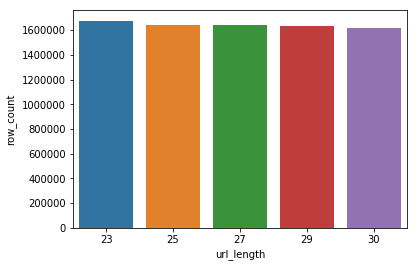

In [71]:
sns.barplot("url_length", "row_count", data=length_stat)

In [72]:
log_with_domains = log_with_regions.withColumn("domain", f.regexp_extract("url", "http:\/\/(.*)\/", 1))

In [73]:
log_with_domains.show(5, False, True)

-RECORD 0---------------------------------------------------------------------------------------
 ip        | 49.105.15.79                                                                       
 timestamp | 20140127041332                                                                     
 url       | http://lenta.ru/5567208                                                            
 size      | 184                                                                                
 code      | 509                                                                                
 ua        | Chrome/5.0 compatible; MSIE 9.0; Windows NT 7.0; Trident/5.0; .NET CLR 2.2.50767;) 
 region    | North Ossetia–Alania                                                               
 domain    | lenta.ru                                                                           
-RECORD 1---------------------------------------------------------------------------------------
 ip        | 49.105.15.79     

In [74]:
length_stat = log_with_domains.groupBy(f.length("url").alias("url_length"), "domain")\
                              .agg(f.count("*").alias("row_count"))\
                              .orderBy("row_count", ascending=False)\
                              .toPandas()

In [75]:
length_stat

,url_length,domain,row_count
0,23,lenta.ru,1676363
1,27,news.mail.ru,1644000
2,25,newsru.com,1639043
3,29,news.yandex.ru,1638174
4,30,news.rambler.ru,1617023


In [76]:
log_with_domains[log_with_domains.domain == "lenta.ru"][["url"]].show(5, False)

+-----------------------+
|url                    |
+-----------------------+
|http://lenta.ru/5567208|
|http://lenta.ru/5567208|
|http://lenta.ru/5567208|
|http://lenta.ru/5567208|
|http://lenta.ru/5567208|
+-----------------------+
only showing top 5 rows



In [77]:
log_with_domains.withColumn("url_length", f.length("url")).corr("url", "url_size")

IllegalArgumentException: 'requirement failed: Currently correlation calculation for columns with dataType StringType not supported.'

## User Defined Functions
The function type of the UDF can be one of the following:
+ **SCALAR**. A scalar UDF defines a transformation: One or more `pandas.Series` -> A `pandas.Series`. calar UDFs are used with `pyspark.sql.DataFrame.withColumn()` and `pyspark.sql.DataFrame.select()`
+ **GROUPED_MAP**. A grouped map UDF defines transformation: A `pandas.DataFrame` -> A `pandas.DataFrame`. Grouped map UDFs are used with `pyspark.sql.GroupedData.apply()`

In [78]:
log_with_domains[["domain"]].distinct().collect()

[Row(domain='news.rambler.ru'),
 Row(domain='news.yandex.ru'),
 Row(domain='newsru.com'),
 Row(domain='news.mail.ru'),
 Row(domain='lenta.ru')]

In [79]:
@f.udf(IntegerType())
def encode_domain(domain):
    mapping = {
        'lenta.ru': 0,
        'newsru.com': 1,
        'news.mail.ru': 2,
        'news.yandex.ru': 3,
        'news.rambler.ru': 4
    }
    return mapping.get(domain)

In [80]:
log_with_domains.withColumn("domain_encoded", encode_domain("domain"))\
                .withColumn("url_length", f.length("url"))\
                .corr("url_length", "domain_encoded")

0.9939371499379468

## Working with time. Count number of days users visited our site

In [81]:
log_with_domains.withColumn("ts", f.unix_timestamp("timestamp", "yyyyMMddHHmmss")).show(5)

AnalysisException: "cannot resolve 'unix_timestamp(`timestamp`, 'yyyyMMddHHmmss')' due to data type mismatch: argument 1 requires (string or date or timestamp) type, however, '`timestamp`' is of bigint type.;;\n'Project [ip#102, timestamp#103L, url#104, size#105, code#106, ua#107, region#986, domain#1701, unix_timestamp(timestamp#103L, yyyyMMddHHmmss, Some(Europe/Moscow)) AS ts#1994]\n+- AnalysisBarrier\n      +- Project [ip#102, timestamp#103L, url#104, size#105, code#106, ua#107, region#986, regexp_extract(url#104, http:\\/\\/(.*)\\/, 1) AS domain#1701]\n         +- Project [ip#102, timestamp#103L, url#104, size#105, code#106, ua#107, region#986]\n            +- Join Inner, (ip#102 = ip#985)\n               :- Repartition 4, true\n               :  +- Relation[ip#102,timestamp#103L,url#104,size#105,code#106,ua#107] csv\n               +- ResolvedHint (broadcast)\n                  +- Relation[ip#985,region#986] csv\n"

In [82]:
log_with_unixts = log_with_domains\
                      .withColumn("ts", f.unix_timestamp(f.col("timestamp").cast("string"), "yyyyMMddHHmmss"))\
                      .drop("timestamp", "url", "size", "code", "ua", "region", "domain")

In [83]:
log_with_unixts.show(5)

+------------+----------+
|          ip|        ts|
+------------+----------+
|49.105.15.79|1390781612|
|49.105.15.79|1390781612|
|49.105.15.79|1390781612|
|49.105.15.79|1390781612|
|49.105.15.79|1390781612|
+------------+----------+
only showing top 5 rows



In [248]:
log_with_unixts.groupBy("ip")\
               .agg(f.min("ts").alias("begin"),
                    f.max("ts").alias("end"))\
               .select("ip", (f.col("end") - f.col("begin")).alias("sec_count"))\
               .select("ip", (f.col("sec_count") / 60.0 / 60.0 / 24.0).alias("days"))\
               .show(5)

+--------------+------------------+
|            ip|              days|
+--------------+------------------+
|  3.183.113.77|115.00466435185184|
|168.255.93.197|115.05512731481481|
|222.131.187.37|115.40369212962963|
|56.167.169.126|114.50332175925926|
| 33.49.147.163|115.72543981481482|
+--------------+------------------+
only showing top 5 rows



In [252]:
log_with_unixts.groupBy("ip")\
               .agg(f.min("ts").astype("timestamp").alias("begin"),
                    f.max("ts").astype("timestamp").alias("end"))\
               .select("ip", (f.datediff("end", "begin").alias("days")))\
               .show(5)

+--------------+----+
|            ip|days|
+--------------+----+
|  3.183.113.77| 115|
|168.255.93.197| 115|
|222.131.187.37| 115|
|56.167.169.126| 114|
| 33.49.147.163| 115|
+--------------+----+
only showing top 5 rows



## Count user sessions

In [256]:
from pyspark.sql import Window

In [258]:
log_with_unixts.select("ip", "ts", f.count("*").over(Window.partitionBy("ip")).alias("cnt"))\
               .orderBy("cnt").show(10)

+------------+----------+----+
|          ip|        ts| cnt|
+------------+----------+----+
|25.62.10.220|1388550613|7020|
|25.62.10.220|1388550613|7020|
|25.62.10.220|1388550613|7020|
|25.62.10.220|1388550613|7020|
|25.62.10.220|1388550613|7020|
|25.62.10.220|1388550613|7020|
|25.62.10.220|1388550613|7020|
|25.62.10.220|1388550613|7020|
|25.62.10.220|1388550613|7020|
|25.62.10.220|1388550613|7020|
+------------+----------+----+
only showing top 10 rows



## Window functions allow to order values inside groups, so you have cool new functions like:
+ `first()`
+ `last()`
+ `lag()`
+ `lead()`

In [264]:
user_window = Window.orderBy("ts").partitionBy("ip")

In [265]:
log_with_unixts.select("ip", "ts",
                       f.row_number().over(user_window).alias("count"),
                       f.lag("ts").over(user_window).alias("lag"),
                       f.lead("ts").over(user_window).alias("lead"))\
               .show(10)

+------------+----------+-----+----------+----------+
|          ip|        ts|count|       lag|      lead|
+------------+----------+-----+----------+----------+
|3.183.113.77|1388580062|    1|      null|1388580062|
|3.183.113.77|1388580062|    2|1388580062|1388580062|
|3.183.113.77|1388580062|    3|1388580062|1388580062|
|3.183.113.77|1388580062|    4|1388580062|1388580062|
|3.183.113.77|1388580062|    5|1388580062|1388580062|
|3.183.113.77|1388580062|    6|1388580062|1388580062|
|3.183.113.77|1388580062|    7|1388580062|1388580062|
|3.183.113.77|1388580062|    8|1388580062|1388580062|
|3.183.113.77|1388580062|    9|1388580062|1388580062|
|3.183.113.77|1388580062|   10|1388580062|1388580062|
+------------+----------+-----+----------+----------+
only showing top 10 rows



In [268]:
log_with_unixts.select("ip", "ts",
                       f.lead("ts").over(user_window).alias("lead"))\
               .select("ip", "ts",
                       (f.col("lead") - f.col("ts")).alias("diff"))\
               .where("diff >= 1800 or diff is NULL")\
               .groupBy("ip").count()\
               .orderBy(f.col("count").desc())\
               .show(30)

+---------------+-----+
|             ip|count|
+---------------+-----+
|  75.208.40.166| 1363|
| 197.72.248.141| 1101|
|  33.49.147.163|  993|
| 222.131.187.37|  711|
|135.124.143.193|  654|
| 168.255.93.197|  589|
| 56.167.169.126|  579|
|   49.203.96.67|  526|
|   49.105.15.79|  480|
| 110.91.102.196|  362|
|247.182.249.253|  270|
| 231.119.88.198|  207|
|   25.62.10.220|  152|
| 181.217.177.35|  137|
| 168.146.187.80|  104|
|   3.183.113.77|   99|
|    14.8.59.211|   57|
+---------------+-----+

